Download and Import Libraries

In [1]:
# some sample libraries are provided here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import twitter_samples

# print out the file ids
import nltk
# nltk.download('twitter_samples')

import emoji
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import textTokenizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
from tabulate import tabulate
import math
from collections import Counter

# twitter_samples.fileids()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ivankwok/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ivankwok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ivankwok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ivankwok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
names = ["ProductId", "ProductName", "Category", "DiscountedPrice", "ActualPrice", "DiscountPercentage", "Rating", "RatingCount", "AboutProduct", "UserId", "UserName", "ReviewId", "ReviewTitle", "ReviewContent", "ImgLink", "ProductLink"]

df = pd.read_csv("amazon.csv", header=0, names=names)
print(df.shape)
# print(df[-5:df.shape[0]])

(1465, 16)


Data Engineering

HelpfulnessNumerator: Number of users who found the review helpful

HelpfulnessDenominator: Number of users who indicated whether they found the review helpful or not

Helpfulness: numerator/ denominator

In [3]:
flatten_list = lambda y:[x for a in y for x in flatten_list(a)] if type(y) is list else [y]

for column in names:
    column = df[column].values.tolist()
    column = flatten_list(column)

Properties of dataset

In [4]:
print(df.nunique())

nan_count = df.isna().sum()
print(nan_count)

ProductId             1351
ProductName           1337
Category               211
DiscountedPrice        550
ActualPrice            449
DiscountPercentage      92
Rating                  28
RatingCount           1143
AboutProduct          1293
UserId                1194
UserName              1194
ReviewId              1194
ReviewTitle           1194
ReviewContent         1212
ImgLink               1412
ProductLink           1465
dtype: int64
ProductId             0
ProductName           0
Category              0
DiscountedPrice       0
ActualPrice           0
DiscountPercentage    0
Rating                0
RatingCount           2
AboutProduct          0
UserId                0
UserName              0
ReviewId              0
ReviewTitle           0
ReviewContent         0
ImgLink               0
ProductLink           0
dtype: int64


In [5]:
df[df['RatingCount'].isna() == True]

,ProductId,ProductName,Category,DiscountedPrice,ActualPrice,DiscountPercentage,Rating,RatingCount,AboutProduct,UserId,UserName,ReviewId,ReviewTitle,ReviewContent,ImgLink,ProductLink
282,B0B94JPY2N,Amazon Brand - Solimo 65W Fast Charging Braide...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹999,80%,3.0,NaN,USB C to C Cable: This cable has type C connec...,AE7CFHY23VAJT2FI4NZKKP6GS2UQ,Pranav,RUB7U91HVZ30,The cable works but is not 65W as advertised,I have a pd supported car charger and I bought...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Amazon-Brand-Charging-Su...
324,B0BQRJ3C47,"REDTECH USB-C to Lightning Cable 3.3FT, [Apple...",Computers&Accessories|Accessories&Peripherals|...,₹249,₹999,75%,5.0,NaN,💎[The Fastest Charge] - This iPhone USB C cabl...,AGJC5O5H5BBXWUV7WRIEIOOR3TVQ,Abdul Gafur,RQXD5SAMMPC6L,Awesome Product,Quick delivery.Awesome ProductPacking was good...,https://m.media-amazon.com/images/I/31-q0xhaTA...,https://www.amazon.in/REDTECH-Lightning-Certif...


In [6]:
df['RatingCount'] = df['RatingCount'].fillna(0)
Summary_nan = df['RatingCount'].isna().sum()
print(Summary_nan)

0


In [7]:
df[df.isna().any(axis=1)]

,ProductId,ProductName,Category,DiscountedPrice,ActualPrice,DiscountPercentage,Rating,RatingCount,AboutProduct,UserId,UserName,ReviewId,ReviewTitle,ReviewContent,ImgLink,ProductLink


Rating Score data engineering

In [8]:
#Inspecting the strange row

# df.query('Rating == "|"')
# df.query('Rating < 2')

In [9]:
df['Rating'] = df['Rating'].str.replace('|', '4.0').astype('float64')

In [10]:
#Creating Categories for Rankings

df['Rating'] = df['Rating'].astype(float)

rating_score = []

for score in df['Rating']:
    if score < 2.0 : rating_score.append('Poor')
    elif score < 3.0 : rating_score.append('Below Average')
    elif score < 4.0 : rating_score.append('Average')
    elif score < 5.0 : rating_score.append('Above Average')
    elif score == 5.0 : rating_score.append('Excellent')

In [11]:
#Creating A new Column and Changing the Data Type

df['rating_score'] = rating_score

df['rating_score'] = df['rating_score'].astype('category')

In [12]:
df['rating_score'].value_counts()

rating_score
Above Average    1108
Average           348
Below Average       6
Excellent           3
Name: count, dtype: int64

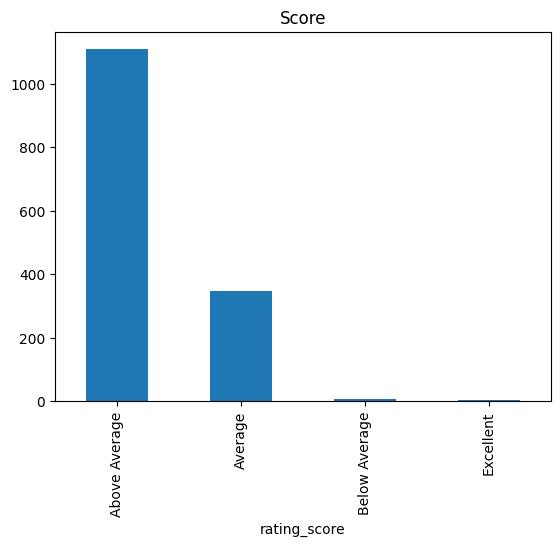

In [13]:
# visualization
df['rating_score'].value_counts().plot(kind='bar')
plt.title("Score")
plt.show()

text preprocessing

In [14]:
def convert_to_lowercase(text):
    '''
    aim: change all texts to lower case
    '''

    text = text.lower()
    
    return text

def emoji_to_word(text):
    '''
    aim: remove all the emoji in the texts
    '''

    text = emoji.demojize(text, delimiters=("", ""))
    
    return text

def emoticons_to_word(text):
    '''
    aim: based on the emoticon dictionary, replace all the emoticons to corresponding word
    The emoticon dictionary is provided in the next block
    '''

    for key in Emoticon_Dictionary.keys():
        text = text.replace(key, Emoticon_Dictionary[key])

    return text

def remove_pattern(text, pattern):
    '''
    aim: remove all the "@users" appears in the texts
    '''

    pattern = "@\S+ "
    text = re.sub(pattern, "", text)

    return text

def remove_punctuation(text):
    '''
    aim: remove all the punctuation from the text given
    Punctuations are characters other than alphaters and digits.
    '''

    string = "" 
    for c in text: 
        if c.isalnum() or c.isspace(): 
            string += c
    text = string
    
    return text

def remove_stopwords(text):
    '''
    aim: remove all stopwords in the texts
    '''

    lst = ['above', 'below', 'over', 'under', 'again', 'once', 'most', 'some', 'no', 'nor', 'not', 'only', 'too', 'very', 'don', 'don\'t']

    stop_words = set([x for x in stopwords.words('english') if x not in lst])

    # print(len(stopwords.words('english')), len(stop_words))

    word_tokens = word_tokenize(text)
    filtered_sentence = []
    for w in word_tokens:
        if (w not in stop_words):
            filtered_sentence.append(w)

    text = (" ").join(filtered_sentence)

    return text

def remove_urls(text):
    '''
    aim: remove all the urls contained inside the texts
    '''

    text = re.sub(r'http\S+', '', text)

    return text

In [15]:
def process_text(name, new_name):
    summary_list = df[name].values.tolist()
    # print(len(summary_list))

    # flatten text list
    flatten_list = lambda y:[x for a in y for x in flatten_list(a)] if type(y) is list else [y]
    summary_list = flatten_list(summary_list)

    tidy_list = []
    for text in summary_list:
        tidy = remove_urls(text)
        tidy = remove_pattern(tidy, pattern="")
        tidy = convert_to_lowercase(tidy)
        tidy = remove_stopwords(tidy)
        tidy = remove_punctuation(tidy)
        tidy_list.append(tidy)

    df[new_name] = tidy_list

In [16]:
process_text('ReviewTitle', 'ReviewTitle')
# print(df[['ReviewTitle']])
process_text('ReviewContent', 'ReviewContent')

In [17]:
title_list = df['ReviewTitle'].values.tolist()
content_list = df['ReviewContent'].values.tolist()

Lemmetization

In [18]:
def lemmatization(text):
    '''
    aim: perform lemmatization on the text
    '''

    lem=[]
    lemmatizer = WordNetLemmatizer()
    for word in text:
        lem_word = lemmatizer.lemmatize(word) # stemming word
        lem.append(lem_word)
    return lem

In [19]:
def tokenization(text):
    '''
    aim: perform tokenization on the text
    '''

    token = word_tokenize(text)
    return token


def lemmetize_list(lst, new_lst):
    text_tokens = []
    for t in lst:
        token = tokenization(t)
        text_tokens.append(token)


    lem_list = []
    for text in text_tokens:
        lem_text = lemmatization(text)
        lem_list.append(" ".join(lem_text))


    # df['lemm_text'] = lem_list
    df[new_lst] = lem_list


lemmetize_list(title_list, 'TidyReviewTitle')
lemmetize_list(content_list, 'TidyReviewContent')

df[["ReviewTitle", "TidyReviewTitle", "ReviewContent", "TidyReviewContent"]].head(5)

,ReviewTitle,TidyReviewTitle,ReviewContent,TidyReviewContent
0,satisfied charging really fast value money ...,satisfied charging really fast value money pro...,looks durable charging fine toono complains c...,look durable charging fine toono complains cha...
1,good braided cable type c device good quality...,good braided cable type c device good quality ...,ordered cable connect phone android auto car ...,ordered cable connect phone android auto car c...
2,good speed earlier versions good product wor...,good speed earlier version good product workin...,not quite durable sturdy good nice product ...,not quite durable sturdy good nice product wor...
3,good product good one nice really nice prod...,good product good one nice really nice product...,good product long wire charges good nice b...,good product long wire charge good nice bought...
4,good original decent good one secondary use ...,good original decent good one secondary use be...,bought instead original apple work 150rs not...,bought instead original apple work 150rs not f...


WordCloud

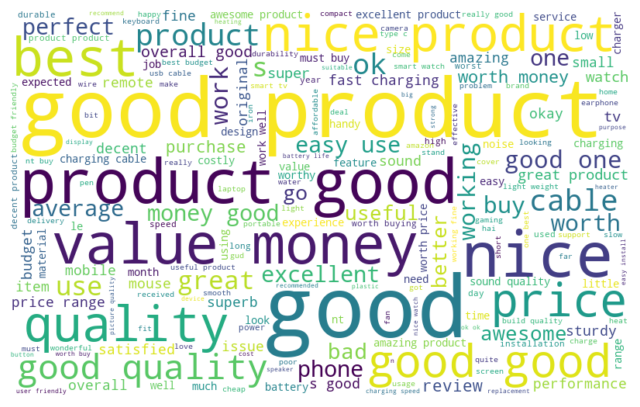

In [20]:
# wordcloud for all
plt.figure(figsize=(8, 6)) 
all_words = ' '.join([text for text in df['TidyReviewTitle']]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color='white').generate(all_words) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

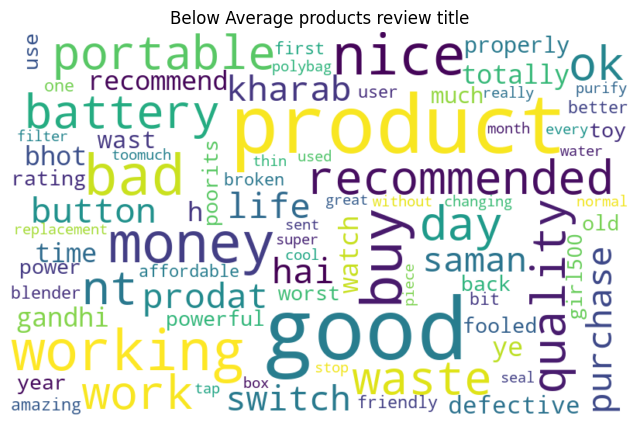

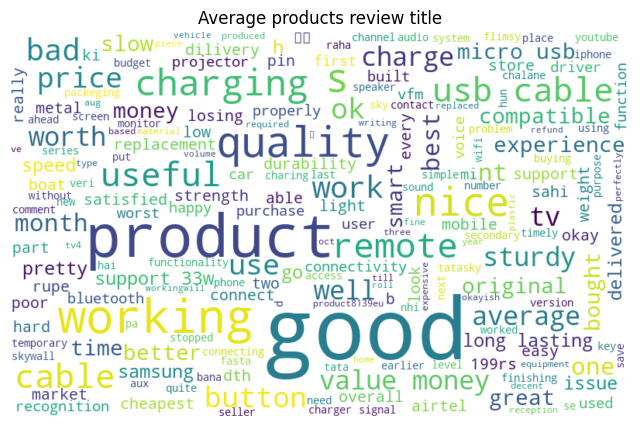

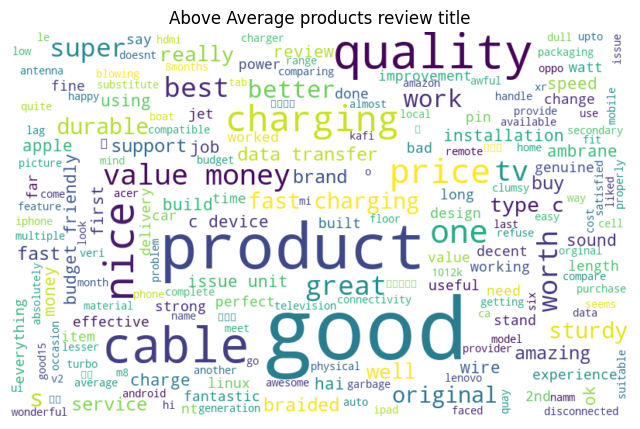

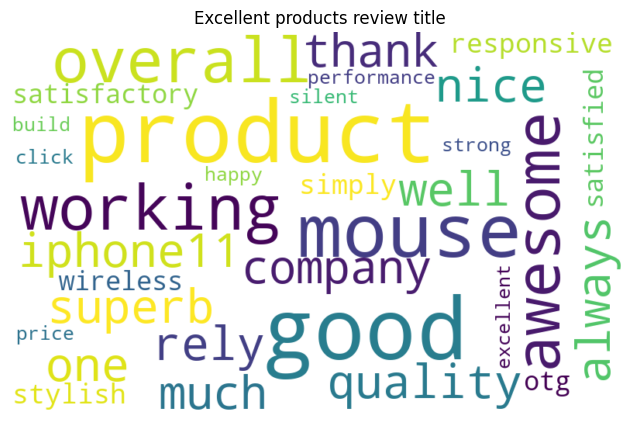

In [21]:
# wordcloud for all

# if score < 2.0 : rating_score.append('Poor')
# elif score < 3.0 : rating_score.append('Below Average')
# elif score < 4.0 : rating_score.append('Average')
# elif score < 5.0 : rating_score.append('Above Average')
# elif score == 5.0 : rating_score.append('Excellent')

scores = ['Below Average', 'Average', 'Above Average', 'Excellent']
for score in scores:
    plt.figure(figsize=(8, 6)) 
    all_words = ' '.join([text for text in df['TidyReviewTitle'][df['rating_score']==score]]) 
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color='white').generate(all_words[:5000]) 
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.title("{} products review title".format(score))
    plt.axis('off') 

    plt.show()

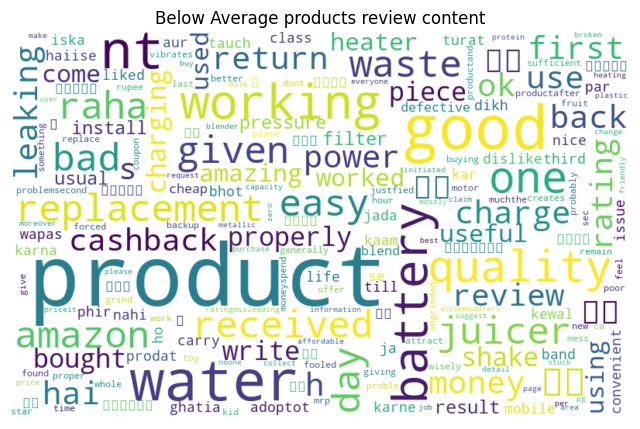

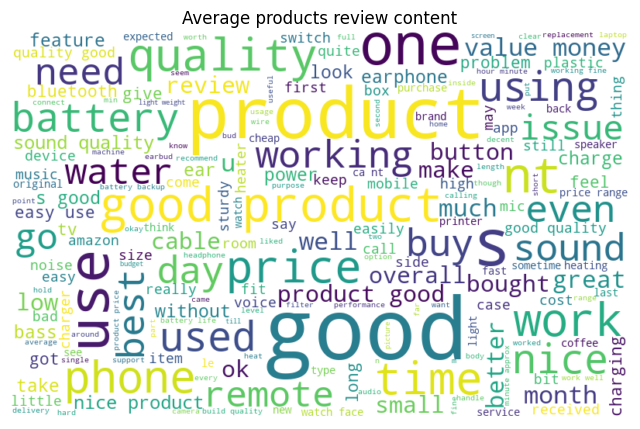

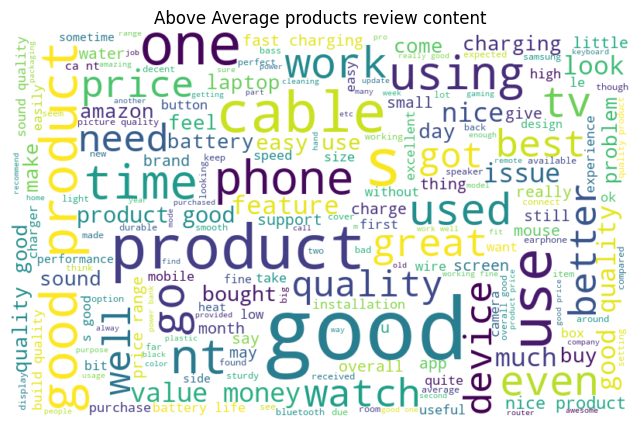

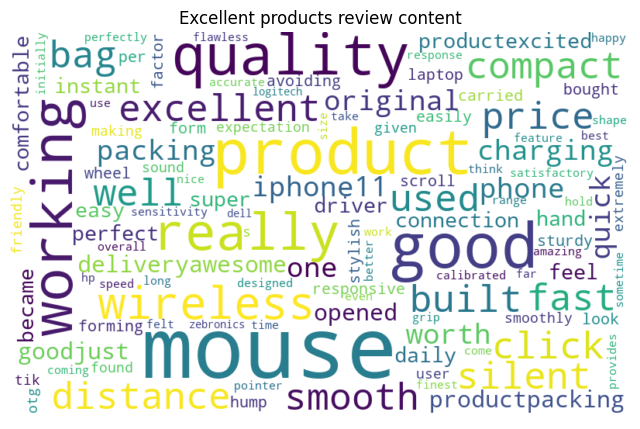

In [22]:
for score in scores:
    plt.figure(figsize=(8, 6)) 
    all_words = ' '.join([text for text in df['TidyReviewContent'][df['rating_score']==score]]) 
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color='white').generate(all_words) 
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.title("{} products review content".format(score))
    plt.axis('off') 

    plt.show()

We now extract the most popular product (Electronics), and visualize their product reviews in wordcloud

In [23]:
#Splitting the Strings in the category column

catsplit = df['Category'].str.split('|', expand=True)

#Renaming category column

catsplit = catsplit.rename(columns={0:'category_1', 1:'category_2', 2:'category_3'})

#Adding categories to the new dataframe

df['category_1'] = catsplit['category_1']
df['category_2'] = catsplit['category_2']

In [24]:
df['category_1'].value_counts()

category_1
Electronics              526
Computers&Accessories    453
Home&Kitchen             448
OfficeProducts            31
MusicalInstruments         2
HomeImprovement            2
Toys&Games                 1
Car&Motorbike              1
Health&PersonalCare        1
Name: count, dtype: int64

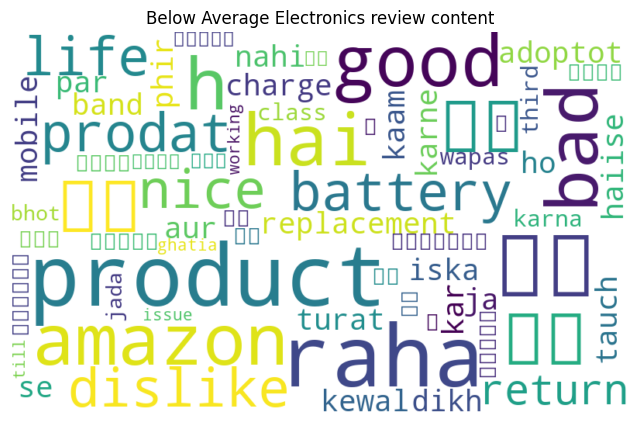

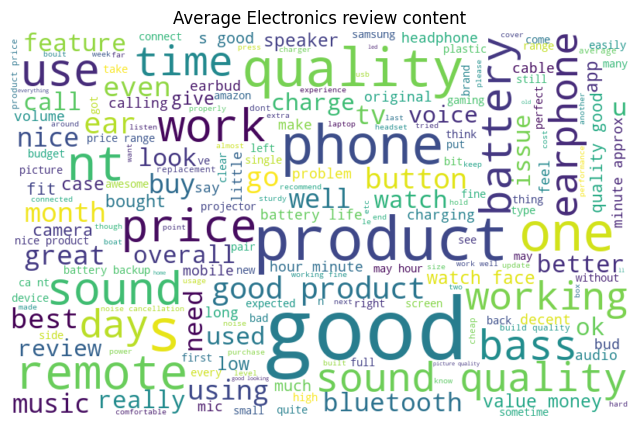

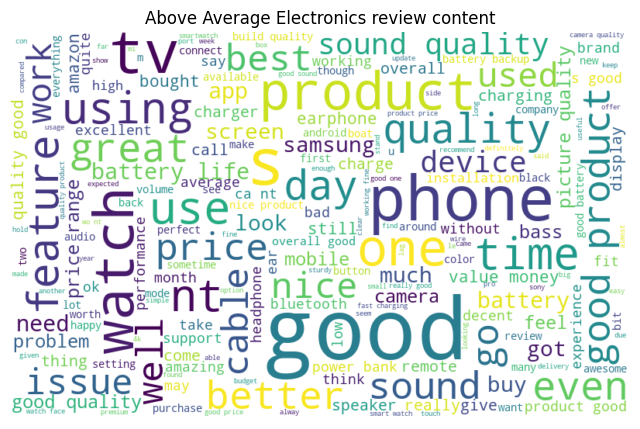

<Figure size 800x600 with 0 Axes>

In [25]:
for score in scores:
    plt.figure(figsize=(8, 6)) 
    all_words = ' '.join([text for text in df['TidyReviewContent'][(df['rating_score']==score) & (df['category_1'] == 'Electronics')]]) 
    if len(all_words)>0:
        wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color='white').generate(all_words) 
        plt.imshow(wordcloud, interpolation="bilinear") 
        plt.title("{} Electronics review content".format(score))
        plt.axis('off') 

        plt.show()